In [1]:
import pandas as pd; pd.set_option('max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['font.family'] = 'Malgun Gothic'
from matplotlib import cm
import seaborn as sns; sns.set(font='Malgun Gothic'); 
import warnings; warnings.filterwarnings(action='ignore')

import yfinance as yf # 야후 파이낸스
import bt             # 백테스트 라이브러리
import pyfolio as pf  # 백테스트 시각화 라이브러리
import talib          # 보조지표 라이브러리

# 변수 정의

In [2]:
# 데이터 수집 기간 및 베이스라인 : rolling, 백테스팅을 위해 여분
start_date_pad = '2003-07-29'
end_date_pad   = '2021-10-29'

# 학습 기간
start_date_train = '2003-09-29'
end_date_train   = '2011-09-28'

# 예측 기간
start_date_pred = '2011-09-29'
end_date_pred   = '2021-09-28'

# 백테스트 기간 : HV_resid 활용을 위해 20일 여분
start_date_bt = '2011-09-29'
end_date_bt   = '2021-08-28'

# 주가 데이터 수집

In [3]:
# 지수
indice_tickers = ['^KS11', '^GSPC', '^IXIC',  '^N225',  '^HSI',     '^FCHI', '^GDAXI']
indice_names   = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax']

# 지수 추종 ETF   : 코스피,   S&P500,  나스닥,   닛케이,     홍콩,       프랑스,   독일,   미 국채
etf_tickers    = ['EWY',   'SPY',   'QQQ',    'EWJ',    'EWH',      'EWQ',   'EWG', 'AGG']
etf_names      = ['kospi', 'sp500', 'nasdaq', 'nikkei', 'hangseng', 'cac',   'dax', 'agg']

# 지수 OHLCV
indice = yf.download(indice_tickers, start=start_date_pad, end=end_date_pad)
# 지수 추종 OHLCV
etf    = yf.download(etf_tickers, start=start_date_pad, end=end_date_pad)

[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  8 of 8 completed


In [4]:
etf['Adj Close']

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
Date,,,,,,,,
2003-07-28,NaN,8.589716,4.700956,24.707073,10.765283,17.662933,27.658081,69.914566
2003-07-29,NaN,8.562789,4.724345,24.390320,10.625307,17.903790,27.449938,69.592484
2003-07-30,NaN,8.475274,4.712650,23.883509,10.695294,17.767305,27.250458,69.424484
2003-07-31,NaN,8.549324,4.765272,24.073563,10.708019,17.422075,27.580025,69.585480
2003-08-01,NaN,8.414691,4.741885,23.788481,10.517147,17.767305,27.285145,68.969383
...,...,...,...,...,...,...,...,...
2021-10-22,113.880913,33.779999,24.680000,68.419998,38.970001,80.360001,374.100006,453.119995
2021-10-25,113.990738,33.810001,24.760000,68.449997,38.639999,81.440002,377.929993,455.549988
2021-10-26,114.200409,33.990002,24.700001,68.459999,38.849998,82.029999,379.119995,455.959991


# 지수와 지수 추종 ETF의 상관관계

In [5]:
pd.concat([indice['Adj Close'], etf['Adj Close']], axis=1).corr().iloc[:7, -7:]

# 코스피 : 0.977490
# sp500 : 0.998325
# 나스닥 : 0.998903
# 닛케이 : 0.976603
# 항셍   : 0.906356
# 프랑스 : 0.883865
# 독일   : 0.952550

,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
^FCHI,0.761684,0.652673,0.891918,0.883865,0.665407,0.657152,0.710768
^GDAXI,0.952550,0.972969,0.902571,0.908758,0.889398,0.886084,0.938418
^GSPC,0.867086,0.918053,0.932788,0.900267,0.838659,0.981866,0.998325
^HSI,0.915971,0.906356,0.755839,0.851663,0.890112,0.661726,0.724927
^IXIC,0.821541,0.884684,0.900776,0.861896,0.822208,0.998903,0.991702
^KS11,0.921939,0.913960,0.783142,0.849054,0.977490,0.796176,0.821399
^N225,0.841868,0.831728,0.976603,0.906331,0.760570,0.875070,0.913039


# 글라이드 패스 함수

In [6]:
def makeGlidePath(etf_ohlcv, glide_weight, risk_weight, start_year):
    
    # 날짜, 위험자산 비중 데이터프레임
    df = pd.DataFrame(
        {
            'Date': [str(year) + '-09-29' for year in range(start_year, 2022)], 
            'RA'  : glide_weight
        }
    )
    
    # 장이 열린 날짜로 조정
    df['Date'] = df.apply(lambda x: etf_ohlcv['Adj Close'].index[etf_ohlcv['Adj Close'].index.get_loc(x['Date'], method='nearest')], axis=1)
    
    # 비위험자산 비중
    df['AGG'] = 1 - df['RA']
    
    # 위험자산 비중
    risk_etfs = ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
    for risk_etf, weight in zip(risk_etfs, risk_weight):
        df[risk_etf] = df['RA'] * weight
    
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(['2003-09-29', '2004-09-29', '2005-09-29', '2006-09-29','2007-09-28', '2008-09-29', '2009-09-29', '2010-09-29','2011-09-29', '2012-09-28', '2013-09-30', '2014-09-29','2015-09-29', '2016-09-29', '2017-09-29', '2018-09-28','2019-09-30', '2020-09-29', '2021-08-28'])
    df.drop('RA', axis=1, inplace=True)
    
    return df

# baseline 변동성

In [7]:
# 위험자산내 비중 [독일,   홍콩,  일본,   프랑스, 한국,   S&P,   나스닥]
risk_weight   = [.0250, .0250, .0375, .0375, .2500, .2000, .4250]

# baseline 변동성의 글라이드 패스 : 안전자산 없이 위험자산으로만 구성(가장 큰 변동성 확인 가능)
gw_baseline = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
gp_baseline = makeGlidePath(etf, gw_baseline, risk_weight, start_year=int(start_date_pad[:4]))
gp_baseline

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
2003-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2004-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2005-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2006-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2007-09-28,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2008-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2009-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2010-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2011-09-29,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425
2012-09-28,0,0.025,0.025,0.0375,0.0375,0.25,0.2,0.425


In [8]:
# 백테스팅의 데이터
baseline_data = etf['Adj Close'].loc[start_date_pad:]

# 백테스팅 전략
baseline_strategy = bt.Strategy(
    'baseline', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_baseline), 
        bt.algos.Rebalance(), 
    ]
)

# 백테스트
baseline_backtest = bt.Backtest(strategy=baseline_strategy, data=baseline_data)
baseline_result   = bt.run(baseline_backtest)

In [9]:
baseline_result.prices

,baseline
2003-07-28,100.000000
2003-07-29,100.000000
2003-07-30,100.000000
2003-07-31,100.000000
2003-08-01,100.000000
...,...
2021-10-22,672.347297
2021-10-25,677.330123
2021-10-26,679.394625
2021-10-27,675.912684


In [10]:
baseline_result.stats # 백테스트 요약 결과

,baseline
start,2003-07-28 00:00:00
end,2021-10-28 00:00:00
rf,0.0
total_return,5.813646
cagr,0.110853
max_drawdown,-0.58885
calmar,0.188253
mtd,0.048472
three_month,0.004992
six_month,0.033975


## 백테스트 결과 시각화

In [11]:
%matplotlib inline
# baseline_result.prices.to_drawdown_series().plot() # MDD(최대낙폭)

In [12]:
baseline_returns = baseline_result.prices.to_returns().iloc[1:, 0]
# baseline_returns.plot() # 일별 수익률

In [13]:
# pyfolio 종합 plot
# pf.create_full_tear_sheet(baseline_returns)

In [14]:
# pf.plot_drawdown_periods(returns=baseline_returns, top=10)

In [15]:
# pf.plot_returns(baseline_returns)

In [16]:
# pf.plot_annual_returns(baseline_returns)

In [17]:
# pf.plot_drawdown_underwater(baseline_returns)

In [18]:
# pf.plot_monthly_returns_dist(baseline_returns)

In [19]:
# pf.plot_monthly_returns_heatmap(baseline_returns)

In [20]:
# pf.plot_monthly_returns_timeseries(baseline_returns)

In [21]:
# pf.plot_return_quantiles(baseline_returns)

In [22]:
# pf.plot_rolling_returns(baseline_returns)

In [23]:
# pf.plot_rolling_sharpe(baseline_returns)

In [24]:
# pf.plot_rolling_volatility(baseline_returns)

## baseline 변동성 데이터

In [25]:
baseline_hv = baseline_result.prices
baseline_hv['HV']          = baseline_hv.iloc[:, 0].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
baseline_hv['HV_pred_5']   = baseline_hv.iloc[:, 1].shift(-5)
baseline_hv['HV_pred_10']  = baseline_hv.iloc[:, 1].shift(-10)
baseline_hv['HV_pred_15']  = baseline_hv.iloc[:, 1].shift(-15)
baseline_hv['HV_pred_20']  = baseline_hv.iloc[:, 1].shift(-20)
baseline_hv['HV_resid_5']  = baseline_hv.iloc[:, 1].diff(-5)
baseline_hv['HV_resid_10'] = baseline_hv.iloc[:, 1].diff(-10)
baseline_hv['HV_resid_15'] = baseline_hv.iloc[:, 1].diff(-15)
baseline_hv['HV_resid_20'] = baseline_hv.iloc[:, 1].diff(-20)

baseline_hv

,baseline,HV,HV_pred_5,HV_pred_10,HV_pred_15,HV_pred_20,HV_resid_5,HV_resid_10,HV_resid_15,HV_resid_20
2003-07-28,100.000000,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2003-07-29,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-07-30,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-07-31,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2003-08-01,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-10-22,672.347297,0.140719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-25,677.330123,0.142808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-26,679.394625,0.114911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-27,675.912684,0.116604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 보조지표

### 사전정의함수

In [26]:
def getPsy(x):
    if x > 0:
        result = 1
    else:
        result = np.nan
    return result

def getRevPlus(a):
    if a > 0:
        result = a
    else:
        result = 0
    return result

def getRevMinus(a):
    if a < 0:
        result = a
    else:
        result = 0
    return result

def getVRplus(a, b):
    if a > 0:
        result = b
    else:
        result = 0
    return result

def getVRminus(a, b):
    if a < 0:
        result = b
    else:
        result = 0
    return result

### 보조지표 함수

In [27]:
def getIndicators(df):
    
    # Change : 변동률
    df['Change'] = df['Adj Close'].pct_change()
    
    # Moving Average : 주가이동평균
    df['MA5'] = talib.MA(df['Adj Close'], timeperiod=5)
    df['MA20'] = talib.MA(df['Adj Close'], timeperiod=20)
    df['MA60'] = talib.MA(df['Adj Close'], timeperiod=60)
    df['MA120'] = talib.MA(df['Adj Close'], timeperiod=120)
    # 가격이동평균 기울기 : (당일 이동평균 - 전날 이동평균) / 전날 이동평균
    df['MA5_gra'] = (df['MA5'] - df['MA5'].shift(1)) / df['MA5'].shift(1)
    df['MA20_gra'] = (df['MA20'] - df['MA20'].shift(1)) / df['MA20'].shift(1)
    df['MA60_gra'] = (df['MA60'] - df['MA60'].shift(1)) / df['MA60'].shift(1)
    df['MA120_gra'] = (df['MA120'] - df['MA120'].shift(1)) / df['MA120'].shift(1)    
    
    # 거래량이동평균
    df['V_MA5'] = talib.MA(df['Volume'], timeperiod=5)
    df['V_MA20'] = talib.MA(df['Volume'], timeperiod=20)
    df['V_MA60'] = talib.MA(df['Volume'], timeperiod=60)
    df['V_MA120'] = talib.MA(df['Volume'], timeperiod=120)
    
    # 지수이동평균
    df['EMA5'] = talib.EMA(df['Adj Close'], timeperiod=5)
    df['EMA20'] = talib.EMA(df['Adj Close'], timeperiod=20)
    df['EMA60'] = talib.EMA(df['Adj Close'], timeperiod=60)
    df['EMA120'] = talib.EMA(df['Adj Close'], timeperiod=120)   
    
    # MACD
    macd, macdsignal, macdhist = talib.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'] = macd
    df['MACD_sig9'] = macdsignal
    df['MACD_OSC'] = macdhist
    
    # Stochastic
    fastk, fastd = talib.STOCHF(df['High'], df['Low'], df['Adj Close'], fastk_period=14, fastd_period=3)
    slowk, slowd = talib.STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=14, slowk_period=5, slowd_period=3)
    df['Fast%K'] = fastk
    df['Fast%D'] = fastd
    df['Slow%K'] = slowk
    df['Slow%D'] = slowd
    
    # RSI: 9일, 14일, 15일, 25일, 28일 (RSI_sig 9일)
    df_index = df.index.astype('str')
    U = np.where(df['Adj Close'].diff(1) > 0, df['Adj Close'].diff(1), 0)
    D = np.where(df['Adj Close'].diff(1) < 0, df['Adj Close'].diff(1)*(-1), 0)
    AU = pd.DataFrame(U, index = df_index).rolling(window=14).mean() # RSI: 14일
    AD = pd.DataFrame(D, index = df_index).rolling(window=14).mean()
    RSI = AU / (AD+AU) * 100
    
    df.insert(len(df.columns), "RSI14", RSI)
    df.insert(len(df.columns), "RSI signal", df['RSI14'].ewm(span=9).mean())
    
    # CCI (14일 기준)
    M = (df['High']+df['Low']+df['Adj Close'])/3
    m = M.rolling(window=14).mean()
    d = abs(M-m).rolling(window=14).mean()
    df['CCI'] =( M - m )/(d*0.015)
    df['CCI'] = np.where(df['CCI'] > 0, df['CCI'] + 0.5, df['CCI'] - 0.5)
    
    # A ratio
    df['A'] = (df['High'] - df['Open']).rolling(window=20).sum() / (df['Open'] - df['Low']).rolling(window=20).sum()
    df['A_Ratio'] = df['A']*100
    
    # B ratio
    df['B'] = (df['High'] - df['Adj Close'].shift(1)).rolling(window=20).sum() / (df['Adj Close'].shift(1) - df['Low']).rolling(window=20).sum()
    df['B_Ratio'] = df['B']*100
    
    
    df.drop(['A', 'B'], axis=1, inplace=True)
    
    # ATR(14일 기준)
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # DMI
    df['UpDI'] = talib.PLUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    df['DownDI'] = talib.MINUS_DI(df['High'], df['Low'],  df['Adj Close'], timeperiod=14)
    
    # MFI
    df['MFI'] = talib.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)
    
    # Momentum
    df['Momentum'] = talib.MOM(df['Adj Close'], timeperiod=12)
    
    # Sonar
    df['EMA9'] = talib.EMA(df['Adj Close'], timeperiod=9)
    df['n_shift_ema'] = df['EMA9'].shift(9)
    df['Sonar'] = df['EMA9'] - df['n_shift_ema']
    df['Sonar_sig5'] = talib.EMA(df['Sonar'], timeperiod=5)
    
    df.drop('EMA9', axis=1, inplace= True)
    
    df.drop('n_shift_ema', axis=1, inplace=True)
    
    # STDEV(20일 표준편차)
    df['STDEV'] = talib.STDDEV(df['Adj Close'], timeperiod=20)
    
    # Sigma(20일) (20일짜리 표준편차 사용)
    df['Sigma'] = ( df['Adj Close'] - df['Adj Close'].rolling(window=20).mean() ) / df['STDEV']
    
    # TRIX(12일) (퍼센트)
    df['TRIX'] = talib.TRIX(df['Adj Close'], timeperiod=12)
    
    # VR : 주가 상승일 거래량 / 주가 하락일 거래량 * 100, 
    df['VRplus']  = df.apply(lambda x: getVRplus(x['Change'], x['Volume']), axis=1)
    df['VRminus'] = df.apply(lambda x: getVRminus(x['Change'], x['Volume']), axis=1)
    
    df['VRplus_rolling']  = df['VRplus'].rolling(window=20).sum() # period: 20
    df['VRminus_rolling'] = df['VRminus'].rolling(window=20).sum()
    
    df['VR'] = df['VRplus_rolling'] / df['VRminus_rolling'] * 100
    
    df.drop(['VRplus', 'VRminus', 'VRplus_rolling', 'VRminus_rolling'], axis=1, inplace=True)
    
    # William's %R (14일)
    df['WILLR'] = talib.WILLR(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # 심리도
    df['psy_temp'] = df.apply(lambda x: getPsy(x['Change']), axis=1)
    df['Psy']      = df['psy_temp'].rolling(window=10).count() / 10 * 100
    df.drop('psy_temp', axis=1, inplace=True)
    
    # 이격도
    df['Disparity20'] = (df['Adj Close'] / df['Adj Close'].rolling(window=20).mean()) * 100
    df['Disparity60'] = (df['Adj Close'] / df['Adj Close'].rolling(window=60).mean()) * 100
    
    # ADX
    df['ADX'] = talib.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)
    
    # Chaikin's OSC
    df['ADOSC'] = talib.ADOSC(df['High'], df['Low'], df['Adj Close'], df['Volume'], fastperiod=3, slowperiod=10)
    
    # 거래량 OSC(10일, 20일, 9일)
    df['Volume_OSC'] = (df['Volume'].rolling(window=10).mean() - df['Volume'].rolling(window=20).mean()) / df['Volume'].rolling(window=10).mean() * 100
    
    # 볼린저 밴드
    df['upperband'], df['middleband'], df['lowerband'] = talib.BBANDS(df['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    
    
    return df

### 보조지표 생성

In [28]:
sum_word = pd.read_csv('./sum_word.csv')
sum_word['date'] = pd.to_datetime(sum_word['date'])
baseline_hv = baseline_hv.merge(sum_word, how='left', left_index=True, right_on='date')

etfs = []
# ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
for i, j in zip(etf['Adj Close'].columns[1:], risk_weight):
    temp_etf = getIndicators(etf.swaplevel(axis=1)[i])
    temp_etf.fillna(0, inplace=True)
    temp_etf = temp_etf.loc[:, 'MA5':] * j
    etfs.append(temp_etf)

baseline_hv = baseline_hv.merge(sum(etfs), how='left', left_on='date', right_index=True)
baseline_hv.set_index('date', inplace=True)
baseline_hv

,baseline,HV,HV_pred_5,HV_pred_10,HV_pred_15,HV_pred_20,HV_resid_5,HV_resid_10,HV_resid_15,HV_resid_20,...,WILLR,Psy,Disparity20,Disparity60,ADX,ADOSC,Volume_OSC,upperband,middleband,lowerband
date,,,,,,,,,,,,,,,,,,,,,
2003-07-28,100.000000,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0.000000,0.000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-29,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,2.750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-30,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,3.125,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-07-31,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,10.625,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2003-08-01,100.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,13.125,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,672.347297,0.140719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.522496,61.750,102.241485,100.217535,21.733995,4.102616e+07,-24.072622,295.681766,285.123539,274.565311
2021-10-25,677.330123,0.142808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.367299,71.000,102.950515,100.954263,21.396078,4.306214e+07,-24.804775,296.701135,285.447644,274.194154
2021-10-26,679.394625,0.114911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-11.088321,80.125,103.079400,101.251089,21.534014,3.273070e+07,-22.229806,298.022674,286.125394,274.228114


In [29]:
hv_resid_mean = baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].mean().values
hv_resid_std  = baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].std(ddof=0).values
print(hv_resid_mean)
print(hv_resid_std)

[-0.00061147 -0.00112474 -0.00162432 -0.00195433]
[0.03692303 0.05987967 0.08102314 0.0991433 ]


array([[<AxesSubplot:title={'center':'HV_resid_5'}>,
        <AxesSubplot:title={'center':'HV_resid_10'}>],
       [<AxesSubplot:title={'center':'HV_resid_15'}>,
        <AxesSubplot:title={'center':'HV_resid_20'}>]], dtype=object)

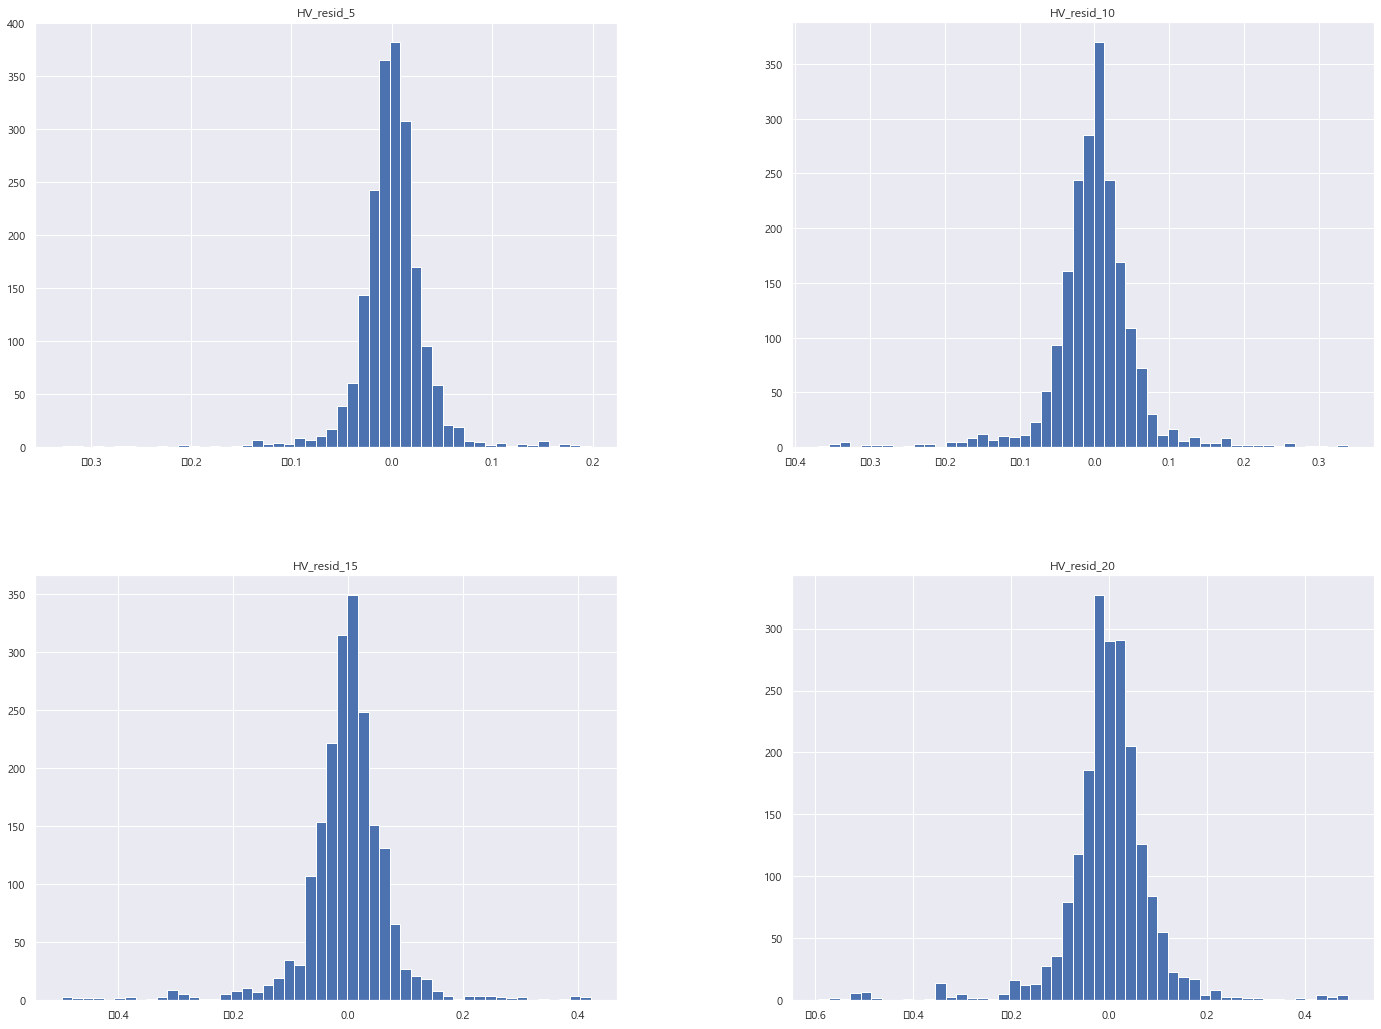

In [30]:
baseline_hv.loc[start_date_train:end_date_train, 'HV_resid_5':'HV_resid_20'].hist(bins=50, figsize=(24, 18))

<AxesSubplot:xlabel='date', ylabel='HV'>

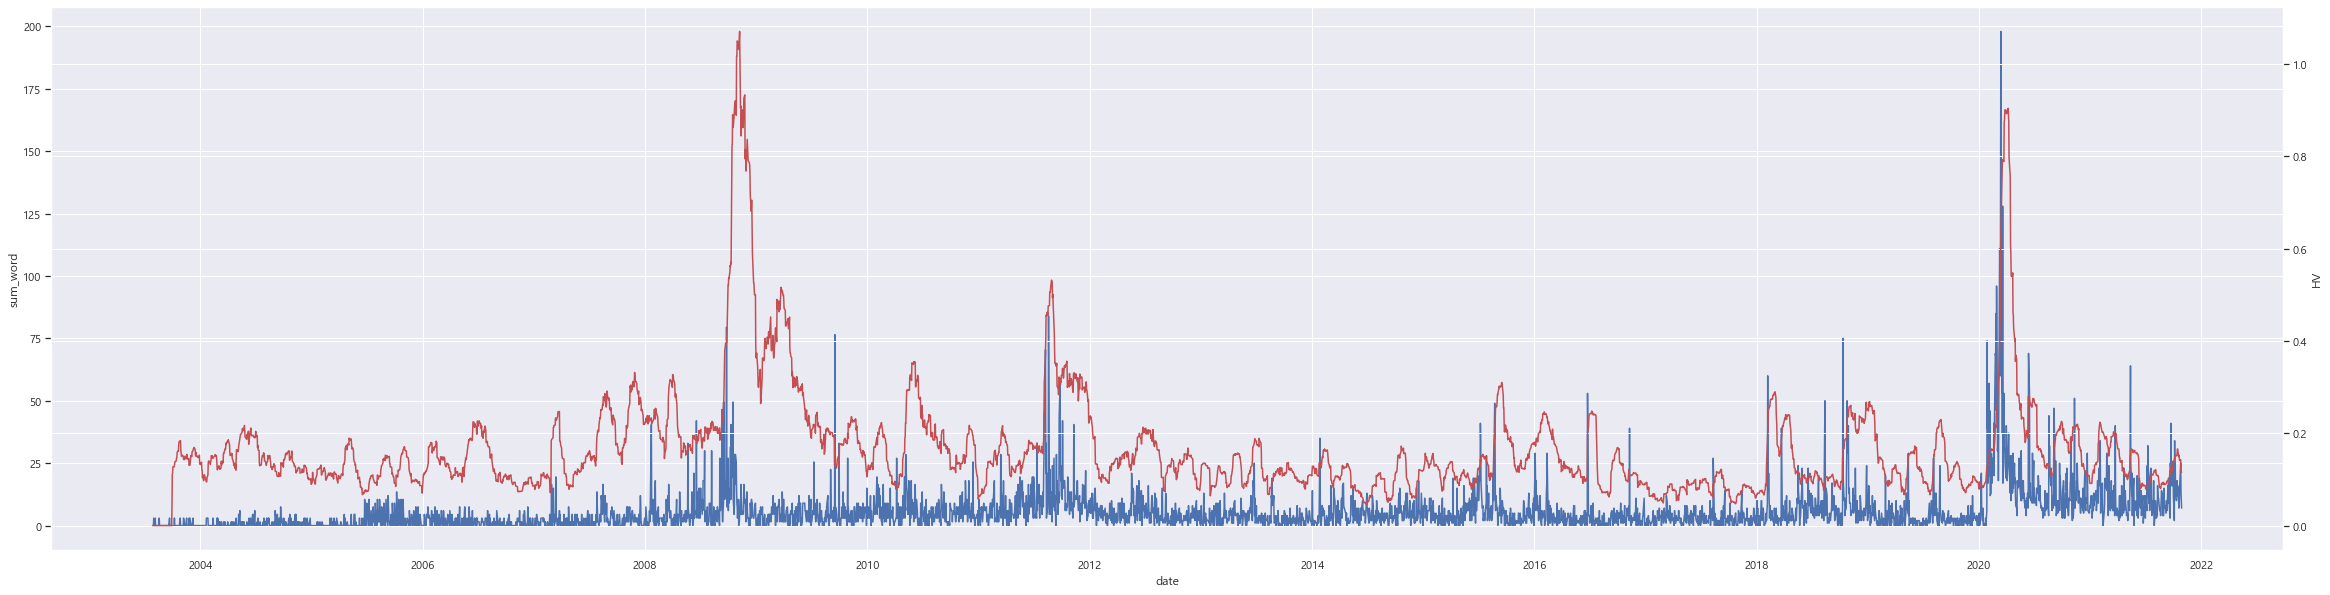

In [31]:
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()

sns.lineplot(ax=ax1, color='b', y=baseline_hv['sum_word'], x=baseline_hv.index)
sns.lineplot(ax=ax2, color='r', y=baseline_hv['HV'], x=baseline_hv.index)

In [32]:
# baseline_hv.to_csv('./baseline_hv.csv')

# 벤치마크 포트폴리오

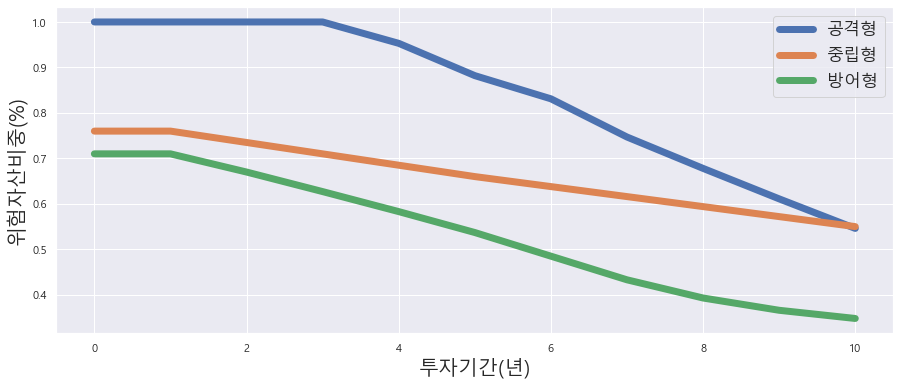

In [33]:
# 10년 벤치마크 글라이드 패스 비중
glide_weight_att = [1.000, 1.000, 1.000, 1.000, .9530, .8820, .8310, .7470, .6780, .6110, .5460]
glide_weight_neu = [.7600, .7600, .7350, .7100, .6850, .6600, .6380, .6160, .5940, .5720, .5500]
glide_weight_def = [.7100, .7100, .6700, .6270, .5830, .5370, .4850, .4330, .3930, .3660, .3480]

# 3년 벤치마크 글라이드 패스 비중
# glide_weight_att = [1.000, 1.000, .8820, .5460]
# glide_weight_neu = [.7600, .7600, .6600, .5500]
# glide_weight_def = [.7100, .7100, .5370, .3480]

f = plt.subplots(figsize=(15, 6))   
sns.lineplot(x=range(len(glide_weight_att)), y=glide_weight_att, lw=7, label='공격형')
sns.lineplot(x=range(len(glide_weight_neu)), y=glide_weight_neu, lw=7, label='중립형')
sns.lineplot(x=range(len(glide_weight_def)), y=glide_weight_def, lw=7, label='방어형')
plt.legend(fontsize=17)                   # 범례 크기
plt.xlabel('투자기간(년)', fontsize=20)     # x축 이름
plt.ylabel('위험자산비중(%)', fontsize=20)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

In [34]:
def makeGlidePath(etf_ohlcv, glide_weight, risk_weight, start_year):
    
    # 날짜, 위험자산 비중 데이터프레임
    df = pd.DataFrame(
        {
            'Date': [str(year) + '-09-29' for year in range(start_year, 2022)], 
            'RA'  : glide_weight
        }
    )
    
    # 장이 열린 날짜로 조정
    df['Date'] = df.apply(lambda x: etf_ohlcv['Adj Close'].index[etf_ohlcv['Adj Close'].index.get_loc(x['Date'], method='nearest')], axis=1)
    
    # 비위험자산 비중
    df['AGG'] = 1 - df['RA']
    
    # 위험자산 비중
    risk_etfs = ['EWG', 'EWH', 'EWJ', 'EWQ', 'EWY', 'QQQ', 'SPY']
    for risk_etf, weight in zip(risk_etfs, risk_weight):
        df[risk_etf] = df['RA'] * weight
    
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(['2011-09-29', '2012-09-28', '2013-09-30', '2014-09-29','2015-09-29', '2016-09-29', '2017-09-29', '2018-09-28','2019-09-30', '2020-09-29', '2021-08-28'])
    df.drop('RA', axis=1, inplace=True)
    
    return df

In [35]:
# 벤치마크 글라이드 패스
gp_bench_att = makeGlidePath(etf, glide_weight_att, risk_weight, start_year=int(start_date_bt[:4]))
gp_bench_neu = makeGlidePath(etf, glide_weight_neu, risk_weight, start_year=int(start_date_bt[:4]))
gp_bench_def = makeGlidePath(etf, glide_weight_def, risk_weight, start_year=int(start_date_bt[:4]))

gp_bench_att

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
2011-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2012-09-28,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2013-09-30,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2014-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2015-09-29,0.047,0.023825,0.023825,0.035737,0.035737,0.23825,0.1906,0.405025
2016-09-29,0.118,0.022050,0.022050,0.033075,0.033075,0.22050,0.1764,0.374850
2017-09-29,0.169,0.020775,0.020775,0.031162,0.031162,0.20775,0.1662,0.353175
2018-09-28,0.253,0.018675,0.018675,0.028012,0.028012,0.18675,0.1494,0.317475
2019-09-30,0.322,0.016950,0.016950,0.025425,0.025425,0.16950,0.1356,0.288150
2020-09-29,0.389,0.015275,0.015275,0.022912,0.022912,0.15275,0.1222,0.259675


In [36]:
data = etf['Adj Close'].loc[start_date_pred:end_date_pred]

bench_att = bt.Strategy(
    'bench_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_att), 
        bt.algos.Rebalance(), 
    ]
)

bench_neu = bt.Strategy(
    'bench_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_neu), 
        bt.algos.Rebalance(), 
    ]
)

bench_def = bt.Strategy(
    'bench_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bench_def), 
        bt.algos.Rebalance(), 
    ]
)

bench_att_backtest = bt.Backtest(strategy=bench_att, data=data)
bench_neu_backtest = bt.Backtest(strategy=bench_neu, data=data)
bench_def_backtest = bt.Backtest(strategy=bench_def, data=data)

bench_result = bt.run(bench_att_backtest, bench_neu_backtest, bench_def_backtest)
bench_hv = bench_result.prices
bench_hv

,bench_att,bench_neu,bench_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894479,97.729424,97.903713
2011-10-03,94.167315,95.755100,96.086556
2011-10-04,96.395753,97.374267,97.578533
...,...,...,...
2021-09-22,332.858737,280.739337,247.180017
2021-09-23,335.484601,282.759538,247.991953
2021-09-24,334.226530,281.729655,247.240794
2021-09-27,333.807669,281.374539,246.919176


In [37]:
for col in bench_hv.columns:
    bench_hv[col + '_HV']          = bench_hv[col].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
    bench_hv[col + '_HV_pred_5']   = bench_hv[col + '_HV'].shift(-5)
    bench_hv[col + '_HV_pred_10']  = bench_hv[col + '_HV'].shift(-10)
    bench_hv[col + '_HV_pred_15']  = bench_hv[col + '_HV'].shift(-15)
    bench_hv[col + '_HV_pred_20']  = bench_hv[col + '_HV'].shift(-20)
    bench_hv[col + '_HV_resid_5']  = bench_hv[col + '_HV'].diff(-5)
    bench_hv[col + '_HV_resid_10'] = bench_hv[col + '_HV'].diff(-10)
    bench_hv[col + '_HV_resid_15'] = bench_hv[col + '_HV'].diff(-15)
    bench_hv[col + '_HV_resid_20'] = bench_hv[col + '_HV'].diff(-20)

bench_hv = bench_hv[start_date_bt:end_date_bt]
bench_hv

,bench_att,bench_neu,bench_def,bench_att_HV,bench_att_HV_pred_5,bench_att_HV_pred_10,bench_att_HV_pred_15,bench_att_HV_pred_20,bench_att_HV_resid_5,bench_att_HV_resid_10,...,bench_neu_HV_resid_20,bench_def_HV,bench_def_HV_pred_5,bench_def_HV_pred_10,bench_def_HV_pred_15,bench_def_HV_pred_20,bench_def_HV_resid_5,bench_def_HV_resid_10,bench_def_HV_resid_15,bench_def_HV_resid_20
2011-09-29,100.000000,100.000000,100.000000,0.000000,0.360796,0.324120,0.305722,0.329484,-0.360796,-0.324120,...,-0.243648,0.000000,0.240327,0.219153,0.207622,0.225634,-0.240327,-0.219153,-0.207622,-0.225634
2011-09-30,96.894479,97.729424,97.903713,0.246493,0.335630,0.316655,0.303504,0.302691,-0.089136,-0.070162,...,-0.043594,0.166388,0.224014,0.214405,0.206888,0.207247,-0.057627,-0.048017,-0.040500,-0.040859
2011-10-03,94.167315,95.755100,96.086556,0.222311,0.372743,0.323141,0.303095,0.305007,-0.150432,-0.100830,...,-0.065348,0.148701,0.252210,0.218676,0.207005,0.210158,-0.103510,-0.069976,-0.058305,-0.061457
2011-10-04,96.395753,97.374267,97.578533,0.355046,0.352095,0.317429,0.307939,0.318359,0.002951,0.037617,...,0.019176,0.235602,0.238040,0.215161,0.209926,0.219601,-0.002438,0.020442,0.025676,0.016002
2011-10-05,98.063525,98.560759,98.664540,0.358459,0.338130,0.313585,0.300349,0.318000,0.020328,0.044874,...,0.020810,0.237142,0.228639,0.212740,0.204687,0.219951,0.008503,0.024402,0.032455,0.017191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,336.107776,283.306730,248.581707,0.061779,0.065352,0.062779,0.066850,0.074235,-0.003572,-0.001000,...,-0.011705,0.041410,0.045991,0.043357,0.045014,0.048638,-0.004581,-0.001947,-0.003604,-0.007228
2021-08-24,337.321343,284.252700,249.028626,0.061111,0.062111,0.063081,0.061912,0.077053,-0.001001,-0.001971,...,-0.015018,0.041283,0.043730,0.042812,0.041094,0.050837,-0.002447,-0.001529,0.000189,-0.009554
2021-08-25,337.413557,284.297515,248.904310,0.060327,0.063101,0.064279,0.062211,0.082518,-0.002774,-0.003953,...,-0.020631,0.040595,0.044427,0.043018,0.041977,0.052376,-0.003832,-0.002423,-0.001382,-0.011781
2021-08-26,335.691178,282.924773,248.093174,0.062003,0.062585,0.065887,0.066675,0.081647,-0.000582,-0.003884,...,-0.018245,0.041777,0.044334,0.044700,0.045354,0.052211,-0.002557,-0.002924,-0.003577,-0.010434


## 전략별 비교

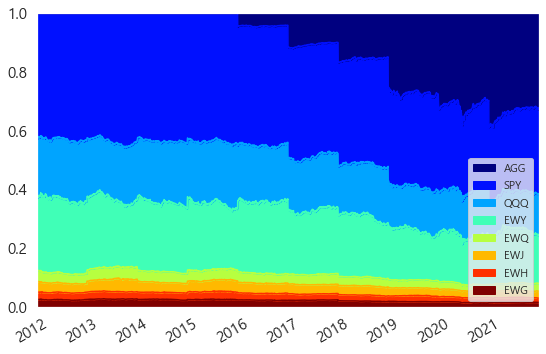

In [38]:
ax = bench_result.get_security_weights(backtest='bench_att').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

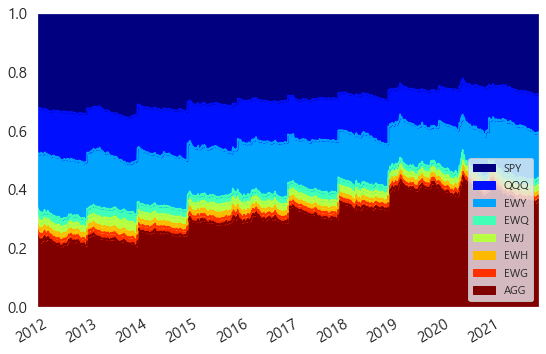

In [39]:
ax = bench_result.get_security_weights(backtest='bench_neu').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

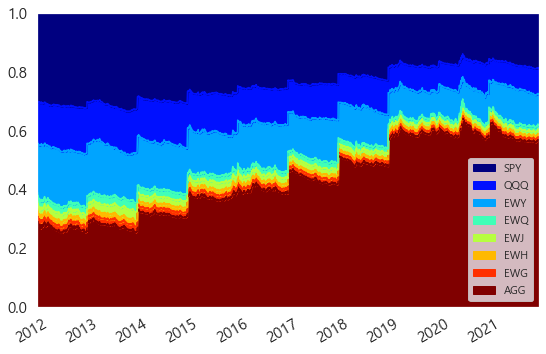

In [40]:
ax = bench_result.get_security_weights(backtest='bench_def').plot.area(
    figsize=(9, 6), legend=False, colormap=cm.jet_r, ylim=[0, 1]
)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles), reversed(labels), loc='lower right')

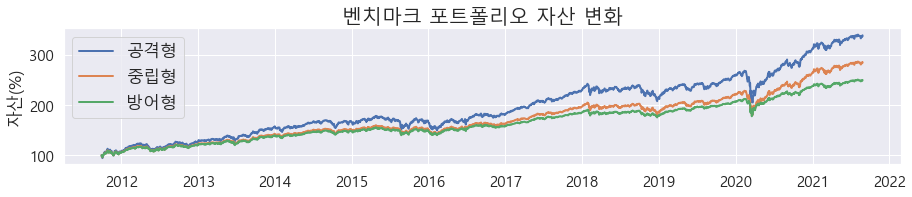

In [41]:
fig, ax = plt.subplots(figsize=(15, 2.5))
sns.lineplot(y='bench_att', label='공격형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_neu', label='중립형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_def', label='방어형', lw=2, x=bench_hv.index, data=bench_hv)

plt.title('벤치마크 포트폴리오 자산 변화', fontsize=20)
plt.legend(fontsize=17, loc='upper left')                   # 범례 크기
# plt.xlabel('연도(년)', fontsize=20)     # x축 이름
plt.ylabel('자산(%)', fontsize=17)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

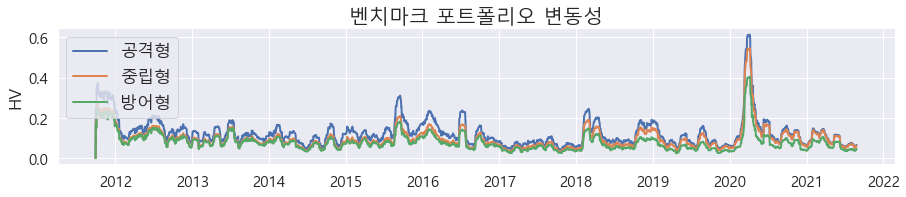

In [42]:
fig, ax = plt.subplots(figsize=(15, 2.5))
sns.lineplot(y='bench_att_HV', label='공격형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_neu_HV', label='중립형', lw=2, x=bench_hv.index, data=bench_hv)
sns.lineplot(y='bench_def_HV', label='방어형', lw=2, x=bench_hv.index, data=bench_hv)

plt.title('벤치마크 포트폴리오 변동성', fontsize=20)
plt.legend(fontsize=17, loc='upper left')                   # 범례 크기
# plt.xlabel('연도(년)', fontsize=20)     # x축 이름
plt.ylabel('HV', fontsize=17)  # y축 이름
plt.rc(['xtick', 'ytick'], labelsize=15)  # 축 수치 크기
plt.show()

# 변동성 예측 기반 포트폴리오

In [43]:
# 예측 글라이드 패스
gp_pred_att = makeGlidePath(etf, glide_weight_att, risk_weight, start_year=int(start_date_bt[:4]))
gp_pred_neu = makeGlidePath(etf, glide_weight_neu, risk_weight, start_year=int(start_date_bt[:4]))
gp_pred_def = makeGlidePath(etf, glide_weight_def, risk_weight, start_year=int(start_date_bt[:4]))

gp_pred_att

,AGG,EWG,EWH,EWJ,EWQ,EWY,QQQ,SPY
2011-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2012-09-28,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2013-09-30,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2014-09-29,0.000,0.025000,0.025000,0.037500,0.037500,0.25000,0.2000,0.425000
2015-09-29,0.047,0.023825,0.023825,0.035737,0.035737,0.23825,0.1906,0.405025
2016-09-29,0.118,0.022050,0.022050,0.033075,0.033075,0.22050,0.1764,0.374850
2017-09-29,0.169,0.020775,0.020775,0.031162,0.031162,0.20775,0.1662,0.353175
2018-09-28,0.253,0.018675,0.018675,0.028012,0.028012,0.18675,0.1494,0.317475
2019-09-30,0.322,0.016950,0.016950,0.025425,0.025425,0.16950,0.1356,0.288150
2020-09-29,0.389,0.015275,0.015275,0.022912,0.022912,0.15275,0.1222,0.259675


In [44]:
data = etf['Adj Close'].loc[start_date_pred:end_date_pred]

pred_att = bt.Strategy(
    'pred_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_att), 
        bt.algos.Rebalance(), 
    ]
)

pred_neu = bt.Strategy(
    'pred_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_neu), 
        bt.algos.Rebalance(), 
    ]
)

pred_def = bt.Strategy(
    'pred_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_pred_def), 
        bt.algos.Rebalance(), 
    ]
)

pred_att_backtest = bt.Backtest(strategy=pred_att, data=data)
pred_neu_backtest = bt.Backtest(strategy=pred_neu, data=data)
pred_def_backtest = bt.Backtest(strategy=pred_def, data=data)

pred_result = bt.run(pred_att_backtest, pred_neu_backtest, pred_def_backtest)
pred_hv = pred_result.prices
pred_hv

,pred_att,pred_neu,pred_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894479,97.729424,97.903713
2011-10-03,94.167315,95.755100,96.086556
2011-10-04,96.395753,97.374267,97.578533
...,...,...,...
2021-09-22,332.858737,280.739337,247.180017
2021-09-23,335.484601,282.759538,247.991953
2021-09-24,334.226530,281.729655,247.240794
2021-09-27,333.807669,281.374539,246.919176


In [45]:
pred = pd.read_csv('./pred_df_final.csv', index_col='date')
pred.index = pd.to_datetime(pred.index)
pred

,pred
date,
2011-10-27,0.268389
2011-10-28,0.287141
2011-10-31,0.275389
2011-11-01,0.278015
2011-11-02,0.290211
...,...
2021-09-22,0.123434
2021-09-23,0.120778
2021-09-24,0.126407


In [46]:
pred_hv = pd.merge(pred_hv, pred, how='left', left_index=True, right_index=True)
pred_hv

,pred_att,pred_neu,pred_def,pred
2011-09-28,100.000000,100.000000,100.000000,NaN
2011-09-29,100.000000,100.000000,100.000000,NaN
2011-09-30,96.894479,97.729424,97.903713,NaN
2011-10-03,94.167315,95.755100,96.086556,NaN
2011-10-04,96.395753,97.374267,97.578533,NaN
...,...,...,...,...
2021-09-22,332.858737,280.739337,247.180017,0.123434
2021-09-23,335.484601,282.759538,247.991953,0.120778
2021-09-24,334.226530,281.729655,247.240794,0.126407
2021-09-27,333.807669,281.374539,246.919176,0.124015


In [47]:
for col in pred_hv.columns:
    pred_hv[col + '_HV']          = pred_hv[col].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252)
    pred_hv[col + '_HV_pred_5']   = pred_hv['pred'].shift(-5)
    pred_hv[col + '_HV_pred_10']  = pred_hv['pred'].shift(-10)
    pred_hv[col + '_HV_pred_15']  = pred_hv['pred'].shift(-15)
    pred_hv[col + '_HV_pred_20']  = pred_hv['pred'].shift(-20)
    pred_hv[col + '_HV_resid_5']  = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_5']
    pred_hv[col + '_HV_resid_10'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_10'] 
    pred_hv[col + '_HV_resid_15'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_15'] 
    pred_hv[col + '_HV_resid_20'] = pred_hv[col + '_HV'] - pred_hv[col + '_HV_pred_20'] 

pred_hv = pred_hv[start_date_bt:end_date_bt]
pred_hv

,pred_att,pred_neu,pred_def,pred,pred_att_HV,pred_att_HV_pred_5,pred_att_HV_pred_10,pred_att_HV_pred_15,pred_att_HV_pred_20,pred_att_HV_resid_5,...,pred_def_HV_resid_20,pred_HV,pred_HV_pred_5,pred_HV_pred_10,pred_HV_pred_15,pred_HV_pred_20,pred_HV_resid_5,pred_HV_resid_10,pred_HV_resid_15,pred_HV_resid_20
2011-09-29,100.000000,100.000000,100.000000,NaN,0.000000,NaN,NaN,NaN,0.268389,NaN,...,-0.268389,NaN,NaN,NaN,NaN,0.268389,NaN,NaN,NaN,NaN
2011-09-30,96.894479,97.729424,97.903713,NaN,0.246493,NaN,NaN,NaN,0.287141,NaN,...,-0.120753,NaN,NaN,NaN,NaN,0.287141,NaN,NaN,NaN,NaN
2011-10-03,94.167315,95.755100,96.086556,NaN,0.222311,NaN,NaN,NaN,0.275389,NaN,...,-0.126688,NaN,NaN,NaN,NaN,0.275389,NaN,NaN,NaN,NaN
2011-10-04,96.395753,97.374267,97.578533,NaN,0.355046,NaN,NaN,NaN,0.278015,NaN,...,-0.042412,NaN,NaN,NaN,NaN,0.278015,NaN,NaN,NaN,NaN
2011-10-05,98.063525,98.560759,98.664540,NaN,0.358459,NaN,NaN,NaN,0.290211,NaN,...,-0.053069,NaN,NaN,NaN,NaN,0.290211,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-23,336.107776,283.306730,248.581707,0.078823,0.061779,0.091057,0.089805,0.097440,0.115225,-0.029278,...,-0.073815,0.546818,0.091057,0.089805,0.097440,0.115225,0.455761,0.457013,0.449377,0.431592
2021-08-24,337.321343,284.252700,249.028626,0.087170,0.061111,0.091017,0.090279,0.096687,0.123434,-0.029907,...,-0.082151,0.688093,0.091017,0.090279,0.096687,0.123434,0.597075,0.597814,0.591405,0.564659
2021-08-25,337.413557,284.297515,248.904310,0.088121,0.060327,0.090356,0.092548,0.094851,0.120778,-0.030029,...,-0.080184,0.681463,0.090356,0.092548,0.094851,0.120778,0.591107,0.588916,0.586612,0.560685
2021-08-26,335.691178,282.924773,248.093174,0.088606,0.062003,0.090799,0.095142,0.092202,0.126407,-0.028796,...,-0.084630,0.669415,0.090799,0.095142,0.092202,0.126407,0.578616,0.574273,0.577213,0.543008


# 리밸런싱 함수

In [48]:
def getOutSignal(a, b):
    if a <= b:
        result_sig = 1
    else:
        result_sig = 0
    return result_sig

def getOutDate(a, b):
    if (a == 1) & (b ==0):
        result_out = 1
    else:
        result_out = 0
    return result_out

def getFillDate(a, b):
    if (a == 1) & (b == 0):
        result_fill = 'out'
    elif (a == 0) & (b == 1):
        result_fill = 'in'
    else:
        result_fill = np.nan
    return result_fill

def getRebalancedGlidePath(
    portfolio_hv, glide_path, 
    resid_diff, out_multiple, in_multiple, rebalance_weight, 
    hv_resid_mean, hv_resid_std, 
):
    
    df = portfolio_hv.copy()
    df.columns = ['portfolio', 'HV', 'HV_resid_5', 'HV_resid_10', 'HV_resid_15', 'HV_resid_20']
    
    if resid_diff == 5:
        df = df[['portfolio', 'HV', 'HV_resid_5']]
        hv_resid_mean = hv_resid_mean[0]
        hv_resid_std  = hv_resid_std[0]
    elif resid_diff == 10:
        df = df[['portfolio', 'HV', 'HV_resid_10']]
        hv_resid_mean = hv_resid_mean[1]
        hv_resid_std  = hv_resid_std[1]
    elif resid_diff == 15:
        df = df[['portfolio', 'HV', 'HV_resid_15']]
        hv_resid_mean = hv_resid_mean[2]
        hv_resid_std  = hv_resid_std[2]
    elif resid_diff == 20:
        df = df[['portfolio', 'HV', 'HV_resid_20']]
        hv_resid_mean = hv_resid_mean[3]
        hv_resid_std  = hv_resid_std[3]
    else:
        print('invalid resid diff')
    df.columns = ['portfolio', 'HV', 'HV_resid']
    
    gp = glide_path.copy()
    
    # 기존 글라이드 패스와 리밸런싱 일자를 구분하기 위한 컬럼
    gp['class'] = 'gp'
    
    # 리밸런싱 시그널
    df['HV_resid_signal'] = hv_resid_mean - out_multiple * hv_resid_std
    df['Out_signal'] = df.apply(lambda x: getOutSignal(x['HV_resid'], x['HV_resid_signal']), axis=1)
    df['Out_signal_shift'] = df['Out_signal'].shift(1)
    
    # 위험자산의 비중을 낮추는 일자
    df['Out_date'] = df.apply(lambda x: getOutDate(x['Out_signal'], x['Out_signal_shift']), axis=1)
    
    # 위험자산의 비중을 이전의 글라이드 패스로 복구할 일자
    df.reset_index(inplace=True)
    out_idx = df[df['Out_date'] == 1].index
    rb_idx  = []
    in_idx  = []
    for out_date_idx in out_idx:
        idx = out_date_idx
        try:
            while df.iloc[idx, 3] <= (hv_resid_mean + in_multiple * hv_resid_std):
                rb_idx.append(idx)
                idx = idx + 1
            in_idx.append(idx)
        except:
            pass
    df['In_date'] = 0
    df.iloc[in_idx, -1] = 1
    
    df['Rebalance'] = 0
    df.iloc[rb_idx, -1] = 1
    
    df['Rebalance_shift'] = df['Rebalance'].shift(1)
    df['Fill_date'] = df.apply(lambda x: getFillDate(x['Rebalance'], x['Rebalance_shift']), axis=1)
    
    df.set_index('index', inplace=True)
    df['class'] = np.nan
    df.iloc[out_idx, -1] = 'out'
    df.iloc[in_idx,  -1] = 'in'
    
    history = df.copy()
    
    
    # 기존 글라이드 패스에 리밸런싱 일자 추가
    gp = pd.concat([gp, df[df['class'].notna()][['class']]], axis=0).sort_index()
    gp.reset_index(inplace=True)
    i = 0
    drop_cnt = 0
    while i < gp.shape[0] + drop_cnt:
        if gp.loc[i, 'class'] == 'out':
            gp.loc[i, 'EWG'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWG']
            gp.loc[i, 'EWH'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWH']
            gp.loc[i, 'EWJ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWJ']
            gp.loc[i, 'EWQ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWQ']
            gp.loc[i, 'EWY'] = (1 - rebalance_weight) * gp.loc[i - 1, 'EWY']
            gp.loc[i, 'QQQ'] = (1 - rebalance_weight) * gp.loc[i - 1, 'QQQ']
            gp.loc[i, 'SPY'] = (1 - rebalance_weight) * gp.loc[i - 1, 'SPY']
            gp.loc[i, 'AGG'] = 1 - gp.loc[i, 'EWG':'SPY'].sum()
        elif gp.loc[i, 'class'] == 'in':
            if gp.loc[i - 1, 'class'] == 'gp':
                gp.loc[i, 'EWG'] = gp.loc[i - 1, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 1, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 1, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 1, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 1, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 1, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 1, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 1, 'AGG']
                gp.drop(axis=0, index=[i - 1], inplace=True)
                drop_cnt = drop_cnt + 1
            elif gp.loc[i - 1, 'class'] == 'out':
                gp.loc[i, 'EWG'] = gp.loc[i - 2, 'EWG']
                gp.loc[i, 'EWH'] = gp.loc[i - 2, 'EWH']
                gp.loc[i, 'EWJ'] = gp.loc[i - 2, 'EWJ']
                gp.loc[i, 'EWQ'] = gp.loc[i - 2, 'EWQ']
                gp.loc[i, 'EWY'] = gp.loc[i - 2, 'EWY']
                gp.loc[i, 'QQQ'] = gp.loc[i - 2, 'QQQ']
                gp.loc[i, 'SPY'] = gp.loc[i - 2, 'SPY']
                gp.loc[i, 'AGG'] = gp.loc[i - 2, 'AGG']
        elif gp.loc[i, 'class'] == 'gp':
            pass
        i = i + 1
    gp.set_index('index', inplace=True)
    
    
    return gp, history

# 리밸런싱 백테스트

In [49]:
# 고객에게 제안 가능한 조건
resid_diff = 20
out_multiple = 0.9
in_multiple  = 0
rebalance_weight = 0.4

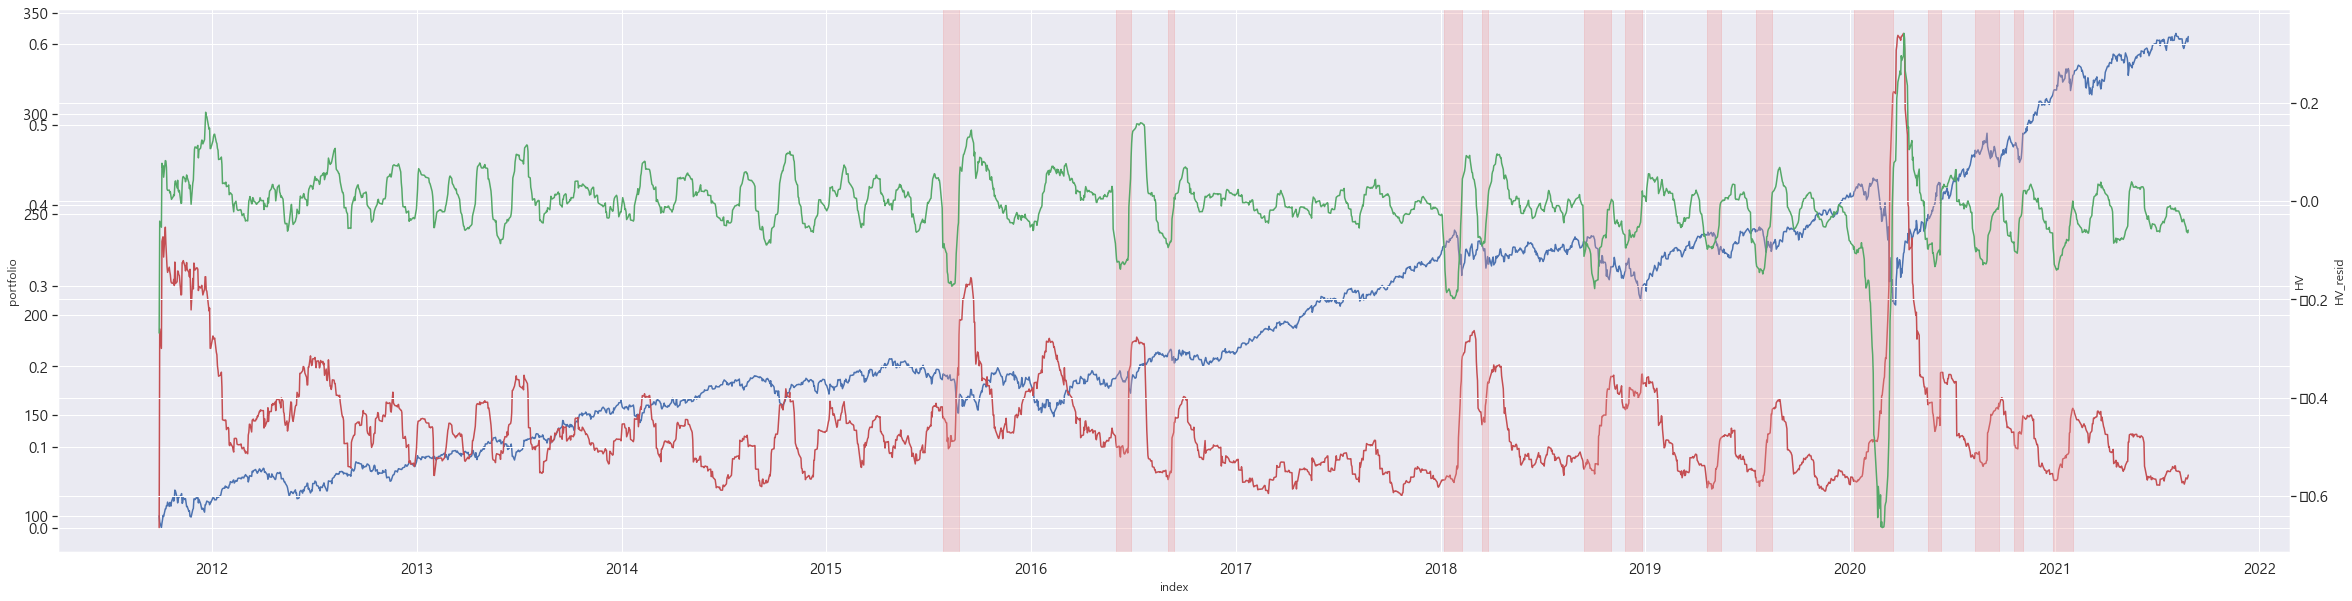

In [50]:
# 공격형 글라이드 패스 리밸런싱
gp_bt_att, history_bt_att = getRebalancedGlidePath(
    pred_hv[['pred_att', 'pred_att_HV', 'pred_att_HV_resid_5', 'pred_att_HV_resid_10', 'pred_att_HV_resid_15', 'pred_att_HV_resid_20']], 
    gp_pred_att, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_att['portfolio'], x=history_bt_att.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_att['HV'], x=history_bt_att.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_att['HV_resid'], x=history_bt_att.index)

out_idx_att = history_bt_att[history_bt_att['Fill_date'] == 'out'].index
in_idx_att  = history_bt_att[history_bt_att['Fill_date'] == 'in'].index
for i, j in zip(out_idx_att, in_idx_att):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

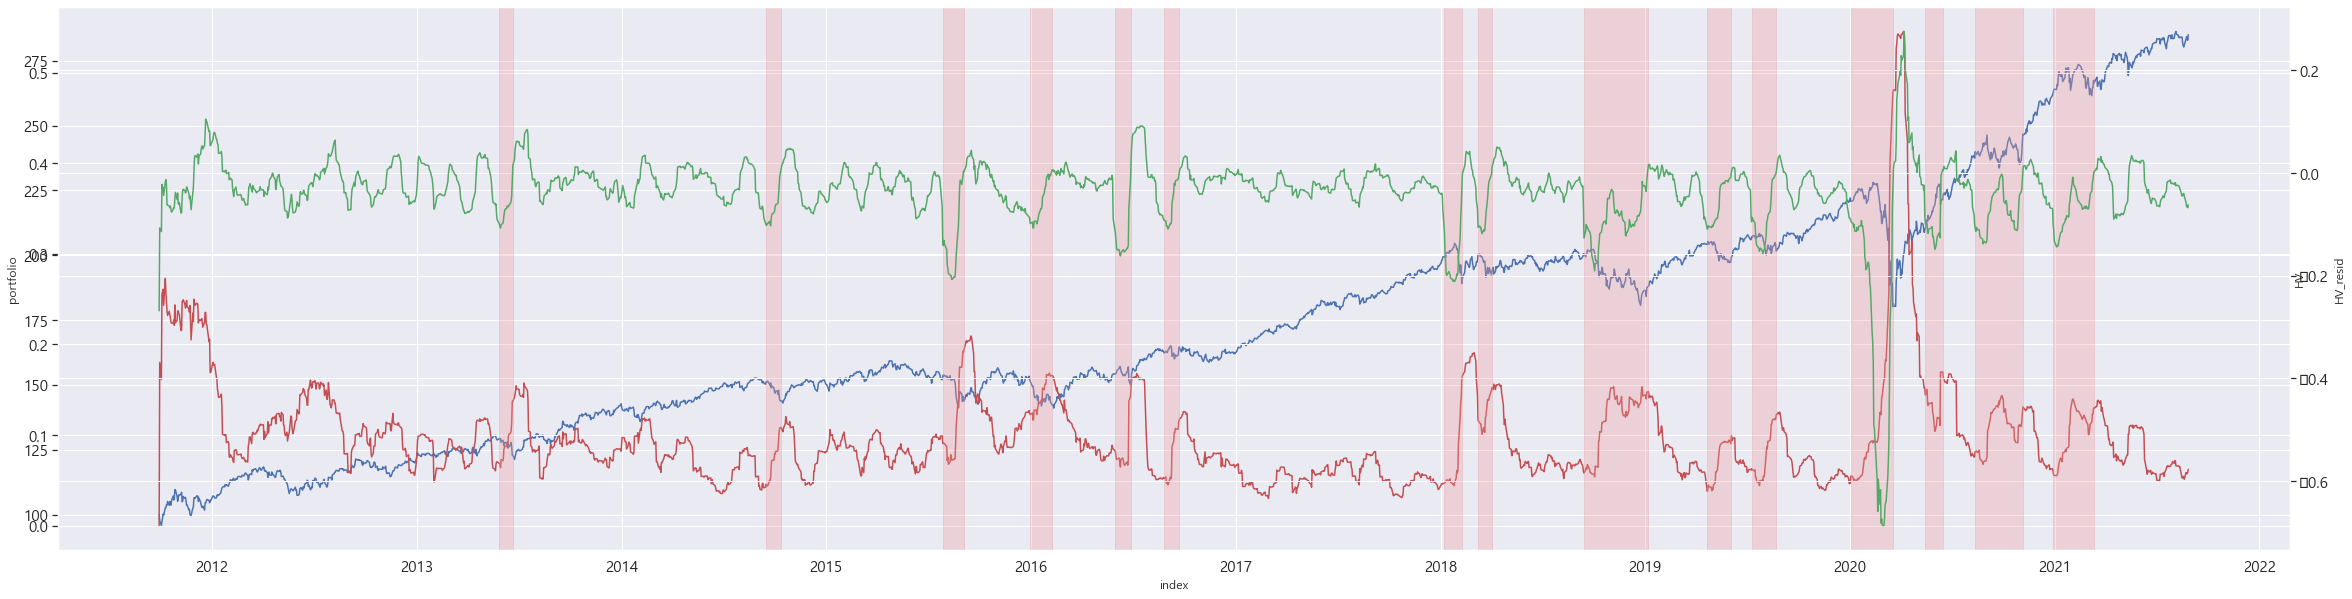

In [51]:
# 중립형 글라이드 패스 리밸런싱
gp_bt_neu, history_bt_neu = getRebalancedGlidePath(
    pred_hv[['pred_neu', 'pred_neu_HV', 'pred_neu_HV_resid_5', 'pred_neu_HV_resid_10', 'pred_neu_HV_resid_15', 'pred_neu_HV_resid_20']], 
    gp_pred_att, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_neu['portfolio'], x=history_bt_neu.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_neu['HV'], x=history_bt_neu.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_neu['HV_resid'], x=history_bt_neu.index)

out_idx_neu = history_bt_neu[history_bt_neu['Fill_date'] == 'out'].index
in_idx_neu  = history_bt_neu[history_bt_neu['Fill_date'] == 'in'].index
for i, j in zip(out_idx_neu, in_idx_neu):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

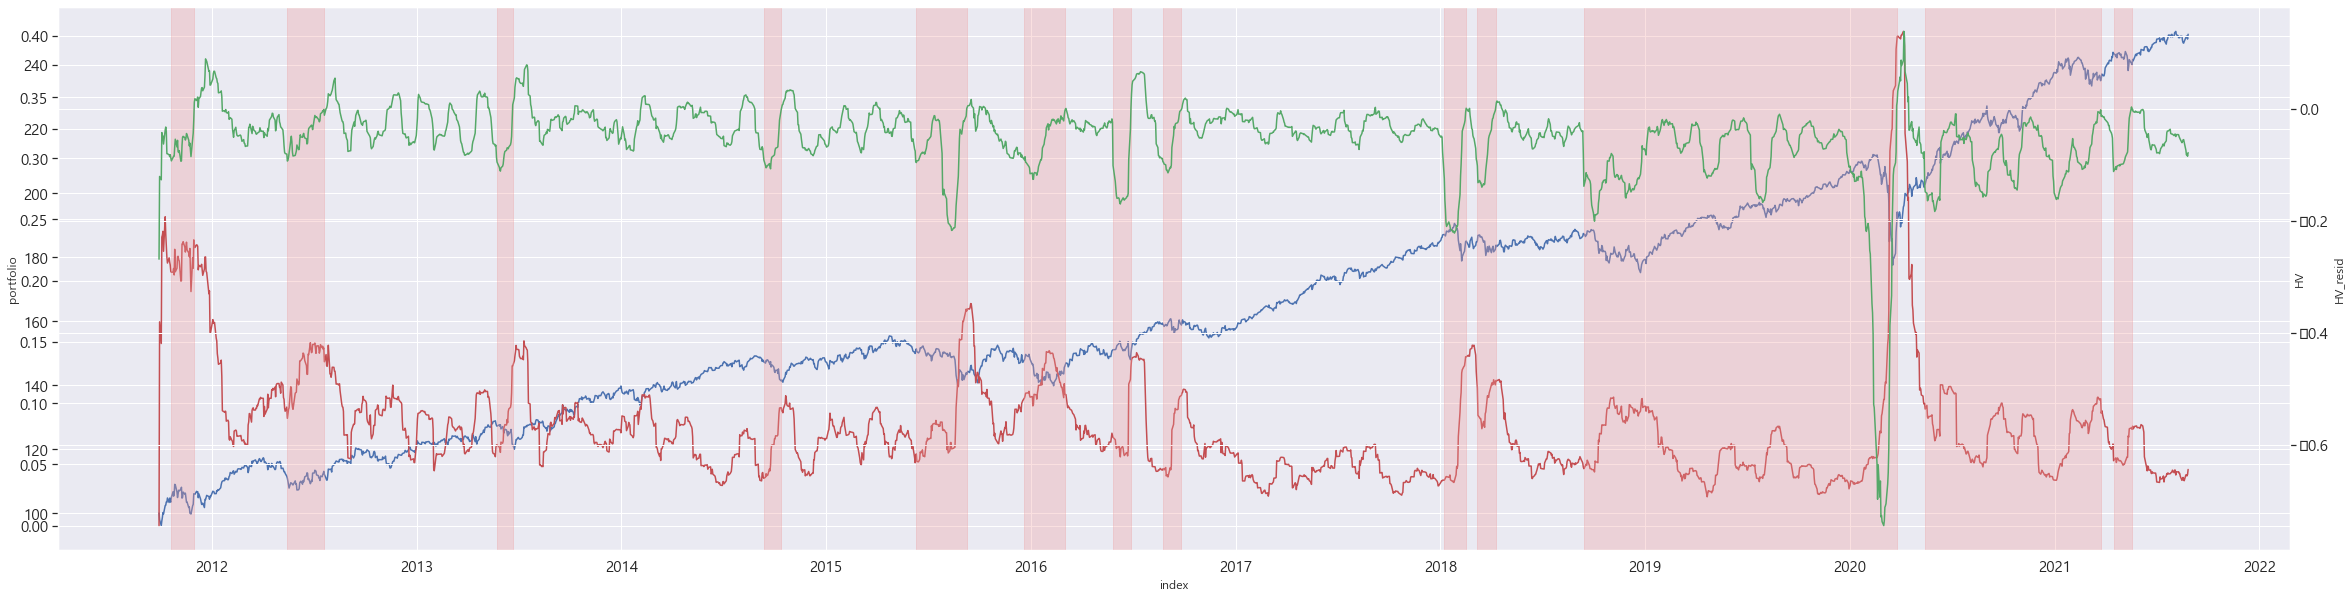

In [52]:
# 방어형 글라이드 패스 리밸런싱
gp_bt_def, history_bt_def = getRebalancedGlidePath(
    pred_hv[['pred_def', 'pred_def_HV', 'pred_def_HV_resid_5', 'pred_def_HV_resid_10', 'pred_def_HV_resid_15', 'pred_def_HV_resid_20']], 
    gp_bench_att, 
    resid_diff=resid_diff, out_multiple=out_multiple, 
    in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
    hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
)
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_def['portfolio'], x=history_bt_def.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_def['HV'], x=history_bt_def.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_def['HV_resid'], x=history_bt_def.index)

out_idx_def = history_bt_def[history_bt_def['Fill_date'] == 'out'].index
in_idx_def  = history_bt_def[history_bt_def['Fill_date'] == 'in'].index
for i, j in zip(out_idx_def, in_idx_def):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

In [53]:
# 전략별 리밸런싱 횟수
print('공격형 : ', len(out_idx_att))
print('중립형 : ', len(out_idx_neu))
print('방어형 : ', len(out_idx_def))

공격형 :  14
중립형 :  15
방어형 :  13


In [54]:
data = etf['Adj Close'].loc[start_date_bt:end_date_bt]

bt_att = bt.Strategy(
    'bt_att', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_att.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_neu = bt.Strategy(
    'bt_neu', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_neu.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_def = bt.Strategy(
    'bt_def', 
    algos=[
        bt.algos.
        bt.algos.SelectAll(), 
        bt.algos.WeighTarget(gp_bt_def.drop('class', axis=1)), 
        bt.algos.Rebalance(), 
    ]
)

bt_att_backtest = bt.Backtest(strategy=bt_att, data=data)
bt_neu_backtest = bt.Backtest(strategy=bt_neu, data=data)
bt_def_backtest = bt.Backtest(strategy=bt_def, data=data)

bt_result = bt.run(bt_att_backtest, bt_neu_backtest, bt_def_backtest)
bt_hv = bt_result.prices
bt_hv

,bt_att,bt_neu,bt_def
2011-09-28,100.000000,100.000000,100.000000
2011-09-29,100.000000,100.000000,100.000000
2011-09-30,96.894479,96.894479,96.894479
2011-10-03,94.167315,94.167315,94.167315
2011-10-04,96.395753,96.395753,96.395753
...,...,...,...
2021-08-23,430.825570,433.550103,362.575167
2021-08-24,432.069337,434.834287,362.626461
2021-08-25,432.133280,434.884110,362.200809
2021-08-26,430.146182,432.884839,361.618116


# 모든 경우의 수

In [101]:
data = etf['Adj Close'].loc[start_date_bt:end_date_bt]

rb_bt_results = []
rows = []

for resid_diff in [10, 15, 20]:
    for out_multiple in [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]:
        for rebalance_weight in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            
            att_row = []
            neu_row = []
            def_row = []
            
            gp_att, history_att = getRebalancedGlidePath(
                pred_hv[['pred_att', 'pred_att_HV', 'pred_att_HV_resid_5', 'pred_att_HV_resid_10', 'pred_att_HV_resid_15', 'pred_att_HV_resid_20']], 
                gp_pred_att, 
                resid_diff=resid_diff, out_multiple=out_multiple, 
                in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            gp_neu, history_neu = getRebalancedGlidePath(
                pred_hv[['pred_neu', 'pred_neu_HV', 'pred_neu_HV_resid_5', 'pred_neu_HV_resid_10', 'pred_neu_HV_resid_15', 'pred_neu_HV_resid_20']], 
                gp_pred_neu, 
                resid_diff=resid_diff, out_multiple=out_multiple, 
                in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            gp_def, history_def = getRebalancedGlidePath(
                pred_hv[['pred_def', 'pred_def_HV', 'pred_def_HV_resid_5', 'pred_def_HV_resid_10', 'pred_def_HV_resid_15', 'pred_def_HV_resid_20']], 
                gp_pred_def, 
                resid_diff=resid_diff, out_multiple=out_multiple, 
                in_multiple=in_multiple, rebalance_weight=rebalance_weight, 
                hv_resid_mean=hv_resid_mean, hv_resid_std=hv_resid_std, 
            )
            
            att = bt.Strategy(
                'att', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_att.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            neu = bt.Strategy(
                'neu', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_neu.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            deff = bt.Strategy(
                'deff', 
                algos=[
                    bt.algos.
                    bt.algos.SelectAll(), 
                    bt.algos.WeighTarget(gp_def.drop('class', axis=1)), 
                    bt.algos.Rebalance(), 
                ]
            )
            
            att_backtest = bt.Backtest(strategy=att, data=data)
            neu_backtest = bt.Backtest(strategy=neu, data=data)
            def_backtest = bt.Backtest(strategy=deff, data=data)
            rb_bt_result = bt.run(att_backtest, neu_backtest, def_backtest)
            rb_bt_results.append(rb_bt_result)
            rb_bt_hv = rb_bt_result.prices
            
            att_row.append('att')
            att_row.append(rb_bt_hv.iloc[-1, 0])
            att_row.append(gp_att[gp_att['class'] == 'out'].shape[0])
            att_row.append(resid_diff)
            att_row.append(out_multiple)
            att_row.append(rebalance_weight)
            rows.append(att_row)
            
            neu_row.append('neu')
            neu_row.append(rb_bt_hv.iloc[-1, 1])
            neu_row.append(gp_neu[gp_neu['class'] == 'out'].shape[0])
            neu_row.append(resid_diff)
            neu_row.append(out_multiple)
            neu_row.append(rebalance_weight)
            rows.append(neu_row)
            
            def_row.append('deff')
            def_row.append(rb_bt_hv.iloc[-1, 2])
            def_row.append(gp_def[gp_def['class'] == 'out'].shape[0])
            def_row.append(resid_diff)
            def_row.append(out_multiple)
            def_row.append(rebalance_weight)
            rows.append(def_row)

rb_bt_stats = pd.DataFrame(rows, columns=['class', 'return', 'rb_count', 'resid_diff', 'out_multiple', 'rebalance_weight'])
rb_bt_stats

,class,return,rb_count,resid_diff,out_multiple,rebalance_weight
0,att,335.161487,91,10,0.2,0.1
1,neu,264.986379,89,10,0.2,0.1
2,deff,239.121604,53,10,0.2,0.1
3,att,328.061093,91,10,0.2,0.2
4,neu,248.547336,89,10,0.2,0.2
5,deff,224.776166,53,10,0.2,0.2
6,att,318.947853,91,10,0.2,0.3
7,neu,234.199783,89,10,0.2,0.3
8,deff,212.803184,53,10,0.2,0.3
9,att,309.171146,91,10,0.2,0.4


In [ ]:
# p1_stats.sort_values('return', ascending=False).head(30)

In [ ]:
# p1_stats.groupby('class').mean()

In [ ]:
# p1_stats.groupby('resid_diff').mean().sort_values('return', ascending=False)

In [ ]:
# p1_stats.groupby('out_multiple').mean().sort_values('return', ascending=False)

In [ ]:
# p1_stats.groupby('rebalance_weight').mean().sort_values('return', ascending=False)

In [ ]:
# p1_stats.describe()

In [ ]:
# sns.relplot(
#     data=p1_stats, x='rb_count', y='return', kind='scatter', 
#     # col='resid_diff', 
#     hue='rebalance_weight', 
#     # col_wrap=2, 
# )

# app.py

## 뷰안1

In [ ]:
# 1번 박스 도넛차트
np.mean(glide_weight_att)

In [ ]:
# 1번 박스 선 차트
glide_weight_att

In [ ]:
# 2번 박스 도넛차트
np.mean(glide_weight_neu)

In [ ]:
# 2번 박스 선 차트
glide_weight_neu

In [ ]:
# 3번 박스 도넛차트
np.mean(glide_weight_def)

In [ ]:
# 3번 박스 선 차트
glide_weight_def

In [ ]:
# 5번 박스 도넛차트
# 독일, 홍콩, 일본, 프랑스, 한국, S&P500, NASDAQ 순서
risk_weight

In [ ]:
# 6번 박스 산점도 준비중

## 뷰안2

In [ ]:
# 1번 박스 선 차트
bench_view2_1_att = bench_hv.loc[:, 'bench_att'].values.tolist() # [::20]
rb_view2_1_att    = bt_hv.loc[start_date_bt:, 'bt_att'].values.tolist()
bench_view2_1_neu = bench_hv.loc[:, 'bench_neu'].values.tolist() # [::20]
rb_view2_1_neu    = bt_hv.loc[start_date_bt:, 'bt_neu'].values.tolist()
bench_view2_1_def = bench_hv.loc[:, 'bench_def'].values.tolist() # [::20]
rb_view2_1_def    = bt_hv.loc[start_date_bt:, 'bt_def'].values.tolist()

In [ ]:
# 2번 박스 선 차트
bench_view2_2_att = bench_hv.loc[:, 'bench_att_HV'].values.tolist() # [::20]
rb_view2_2_att    = (bt_hv.loc[:, 'bt_att'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()
bench_view2_2_neu = bench_hv.loc[:, 'bench_neu_HV'].values.tolist() # [::20]
rb_view2_2_neu    = (bt_hv.loc[:, 'bt_neu'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()
bench_view2_2_def = bench_hv.loc[:, 'bench_def_HV'].values.tolist() # [::20]
rb_view2_2_def    = (bt_hv.loc[:, 'bt_def'].pct_change().rolling(window=20, min_periods=0, center=False).std(ddof=0) * np.sqrt(252))[1:].values.tolist()

In [ ]:
# 3번 박스 선 차트 : 공격형
pd.concat(
    [
        bench_hv['bench_att'].to_drawdown_series(), 
        bt_hv['bt_att'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(30, 10))

In [ ]:
# 3번 박스 선 차트 : 중립형
pd.concat(
    [
        bench_hv['bench_neu'].to_drawdown_series(), 
        bt_hv['bt_neu'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(30, 10))

In [ ]:
# 3번 박스 선 차트 : 방어형
pd.concat(
    [
        bench_hv['bench_def'].to_drawdown_series(), 
        bt_hv['bt_def'].to_drawdown_series()[1:]
    ], axis=1
).plot(figsize=(30, 10))

In [ ]:
# 4번 박스 : 공격형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_att['portfolio'], x=history_bt_att.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_att['HV'], x=history_bt_att.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_att['HV_resid'], x=history_bt_att.index)
# sns.lineplot(ax=ax4, color='k', y=bench_hv['bench_att'].to_drawdown_series(), x=history_bt_att.index)

out_idx_att = history_bt_att[history_bt_att['Fill_date'] == 'out'].index
in_idx_att  = history_bt_att[history_bt_att['Fill_date'] == 'in'].index
for i, j in zip(out_idx_att, in_idx_att):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

In [ ]:
# 4번 박스 : 중립형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_neu['portfolio'], x=history_bt_neu.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_neu['HV'], x=history_bt_neu.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_neu['HV_resid'], x=history_bt_neu.index)

out_idx_neu = history_bt_neu[history_bt_neu['Fill_date'] == 'out'].index
in_idx_neu  = history_bt_neu[history_bt_neu['Fill_date'] == 'in'].index
for i, j in zip(out_idx_neu, in_idx_neu):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

In [ ]:
# 4번 박스 : 방어형 리밸런싱
fig, ax1 = plt.subplots(figsize=(40, 10))
ax2 = ax1.twinx()
ax3 = ax2.twinx()
sns.lineplot(ax=ax1, color='b', y=history_bt_def['portfolio'], x=history_bt_def.index)
sns.lineplot(ax=ax2, color='r', y=history_bt_def['HV'], x=history_bt_def.index)
sns.lineplot(ax=ax3, color='g', y=history_bt_def['HV_resid'], x=history_bt_def.index)

out_idx_def = history_bt_def[history_bt_def['Fill_date'] == 'out'].index
in_idx_def  = history_bt_def[history_bt_def['Fill_date'] == 'in'].index
for i, j in zip(out_idx_def, in_idx_def):
    ax3.axvspan(i, j, color='#EF9A9A', alpha=0.3)

In [ ]:
# 5번, 6번 박스 방사형 수치
bench_view2_56_att = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_sortino', 'yearly_mean', 'yearly_vol'], 'bench_att'].values.tolist()
rb_view2_56_att    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_sortino', 'yearly_mean', 'yearly_vol'], 'bt_att'].values.tolist()
bench_view2_56_neu = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_sortino', 'yearly_mean', 'yearly_vol'], 'bench_neu'].values.tolist()
rb_view2_56_neu    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_sortino', 'yearly_mean', 'yearly_vol'], 'bt_neu'].values.tolist()
bench_view2_56_def = bench_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_sortino', 'yearly_mean', 'yearly_vol'], 'bench_def'].values.tolist()
rb_view2_56_def    = bt_result.stats.loc[['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_sortino', 'yearly_mean', 'yearly_vol'], 'bt_def'].values.tolist()

pd.DataFrame(
    {
        'bench_att': bench_view2_56_att, 
        'rb_att': rb_view2_56_att, 
        'bench_neu': bench_view2_56_neu, 
        'rb_neu': rb_view2_56_neu, 
        'bench_def': bench_view2_56_def, 
        'rb_def': rb_view2_56_def
    }, 
    index=['total_return', 'cagr', 'max_drawdown', 'calmar', 'yearly_sharpe', 'yearly_sortino', 'yearly_mean', 'yearly_vol']
)

In [ ]:
bench_hv

In [ ]:
bench_result.stats